In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

In [4]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,1N4BZ0CP5G,King,Seattle,WA,98125.0,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,46.0,349455557,POINT (-122.30253 47.72656),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
1,KNDJX3AEXG,King,Renton,WA,98058.0,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93.0,31950.0,11.0,210641315,POINT (-122.08747 47.4466),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
2,5YJ3E1EB2J,King,Seattle,WA,98115.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,43.0,171417494,POINT (-122.31676 47.68156),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
3,1C4RJXN64R,Kitsap,Bremerton,WA,98312.0,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,26.0,262542927,POINT (-122.65223 47.57192),PUGET SOUND ENERGY INC,5.303508e+10
4,5YJ3E1EB1J,Thurston,Olympia,WA,98512.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,35.0,110432815,POINT (-122.9131 47.01359),PUGET SOUND ENERGY INC,5.306701e+10


In [ ]:
# 1. Data Cleaning

In [ ]:
# missing values exist in the dataset

In [5]:
df.isnull().sum()

,0
VIN (1-10),0
County,4
City,4
State,0
Postal Code,4
Model Year,0
Make,0
Model,0
Electric Vehicle Type,0
Clean Alternative Fuel Vehicle (CAFV) Eligibility,0


In [ ]:
# missing or zero values in the Base MSRP and Electric Range columns be handled

In [6]:
df['Base MSRP'].replace(0, np.nan, inplace=True)
df['Electric Range'].replace(0, np.nan, inplace=True)

/tmp/ipython-input-6-2687480887.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Base MSRP'].replace(0, np.nan, inplace=True)
/tmp/ipython-input-6-2687480887.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [ ]:
# duplicate records in the dataset and manage them

In [7]:
df.drop_duplicates(subset=['VIN (1-10)', 'County', 'Model Year'], inplace=True)

In [ ]:
# VINs be anonymized while maintaining uniqueness

In [8]:
df['vin_hash'] = df['VIN (1-10)'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())
df.drop(columns=['VIN (1-10)'], inplace=True)

In [ ]:
# Vehicle Location (GPS coordinates) be cleaned

In [9]:
coords = df['Vehicle Location'].str.extract(r'\(([-\d\.]+)\s+([-\d\.]+)\)')
df[['Longitude','Latitude']] = coords.astype(float)

In [ ]:
# 2. Data Exploration

In [ ]:
# top 5 most common EV

In [10]:
df['Make_Model'] = df['Make'].astype(str) + ' ' + df['Model'].astype(str)

In [11]:
top_5 = df['Make_Model'].value_counts().head(5)
print("Top 5 EV Makes and Models:\n", top_5)

Top 5 EV Makes and Models:
 Make_Model
TESLA MODEL 3     4033
TESLA MODEL Y     3960
NISSAN LEAF       3221
TESLA MODEL S     2840
CHEVROLET VOLT    2511
Name: count, dtype: int64


In [ ]:
#distribution of EVs by county  has the most registrations

In [24]:
print(df['County'].value_counts().head(10))

County
King         12606
Snohomish     7398
Pierce        6569
Clark         5478
Kitsap        4252
Thurston      4085
Spokane       3488
Whatcom       3280
Benton        2070
Island        1928
Name: count, dtype: int64


In [ ]:
# EV adoption changed over different model years

In [13]:
df = df[pd.to_numeric(df['Model Year'], errors='coerce').notnull()]
df['Model Year'] = df['Model Year'].astype(int)

In [14]:
model_year_counts = df['Model Year'].value_counts().sort_index()
print("EVs per model year:\n", model_year_counts.tail(10))

EVs per model year:
 Model Year
2017     3035
2018     3616
2019     3367
2020     3667
2021     5660
2022     8354
2023    12669
2024    13510
2025     6731
2026      172
Name: count, dtype: int64


In [ ]:
#average electric range of EVs in the dataset

In [17]:
print(df['Electric Range'].mean())

86.48425208031581


In [ ]:
# percentage of EVs are eligible for Clean Alternative Fuel Vehicle (CAFV)

In [21]:
print(df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts(normalize=True) * 100)

Clean Alternative Fuel Vehicle (CAFV) Eligibility
Eligibility unknown as battery range has not been researched    48.631625
Clean Alternative Fuel Vehicle Eligible                         35.478603
Not eligible due to low battery range                           15.889772
Name: proportion, dtype: float64


In [ ]:
#  electric range vary across different makes and models

In [26]:
df = df.dropna(subset=['Electric Range', 'Make', 'Model'])


In [27]:
df['Make_Model'] = df['Make'] + ' ' + df['Model']

In [28]:
range_by_model = df.groupby('Make_Model')['Electric Range'].mean().sort_values(ascending=False)

In [29]:
print("Top 10 EVs by Average Electric Range:")
print(range_by_model.head(10))

Top 10 EVs by Average Electric Range:
Make_Model
PORSCHE MACAN        302.871795
TESLA MODEL Y        291.000000
HYUNDAI KONA         258.000000
TESLA MODEL 3        245.876309
CHEVROLET BOLT EV    244.416258
TESLA MODEL X        241.538816
TESLA ROADSTER       235.972222
JAGUAR I-PACE        234.000000
POLESTAR PS2         233.000000
TESLA MODEL S        228.156205
Name: Electric Range, dtype: float64


In [ ]:
# average Base MSRP for each EV model

In [30]:
df = df[df['Base MSRP'] > 0]

In [31]:
avg_price_by_model = df.groupby('Make_Model')['Base MSRP'].mean().sort_values(ascending=False)


In [32]:
print("Top 10 EV Models by Average Base MSRP:")
print(avg_price_by_model.head(10))

Top 10 EV Models by Average Base MSRP:
Make_Model
PORSCHE 918         845000.000000
PORSCHE PANAMERA    184400.000000
TESLA ROADSTER      106237.500000
FISKER KARMA        102000.000000
BMW 740E             90227.777778
PORSCHE CAYENNE      81100.000000
CADILLAC CT6         75095.000000
TESLA MODEL S        68528.389155
VOLVO XC90           64950.000000
BMW 530E             54253.289474
Name: Base MSRP, dtype: float64


In [ ]:
# regional trends in EV adoption (e.g., urban vs. rural areas)

In [33]:
county_counts = df['County'].value_counts()

In [34]:
print("Top Counties (Urban likely):")
print(county_counts.head(5))

Top Counties (Urban likely):
County
King         458
Snohomish    208
Pierce       207
Clark        135
Kitsap        91
Name: count, dtype: int64


In [35]:
print("\nBottom Counties (Rural likely):")
print(county_counts.tail(5))


Bottom Counties (Rural likely):
County
Skamania       1
El Paso        1
Monterey       1
Multnomah      1
Leavenworth    1
Name: count, dtype: int64


In [ ]:
# 3.Data Visualization

In [ ]:
# bar chart showing the top 5 EV makes and models by count

<Axes: xlabel='Make_Model'>

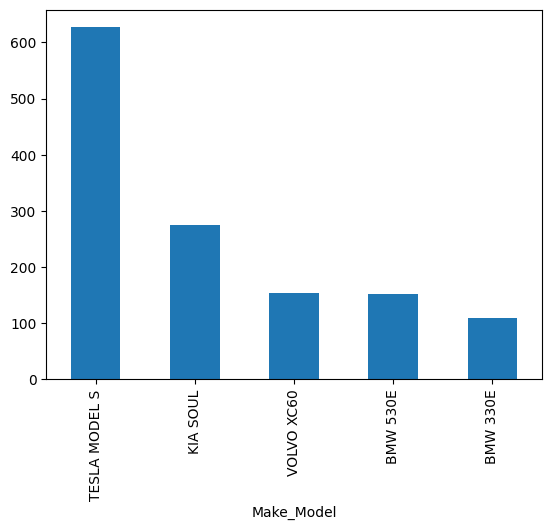

In [36]:
df['Make_Model'] = df['Make'] + ' ' + df['Model']
df['Make_Model'].value_counts().head(5).plot(kind='bar')

In [ ]:
#heatmap or choropleth map to visualize EV distribution by county

<Axes: ylabel='County'>

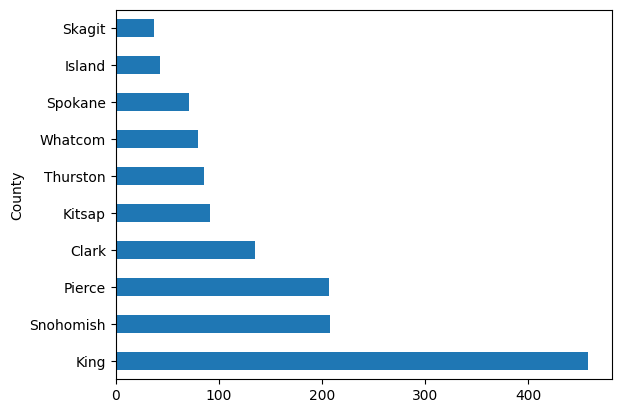

In [37]:
df['County'].value_counts().head(10).plot(kind='barh')

In [ ]:
# line graph showing the trend of EV adoption by model year

<Axes: xlabel='Model Year'>

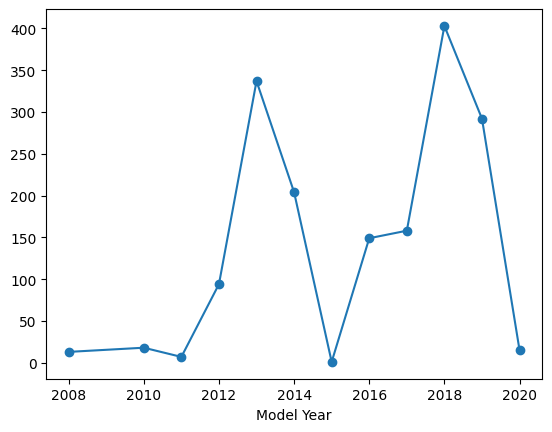

In [38]:
df['Model Year'] = df['Model Year'].astype(int)
df['Model Year'].value_counts().sort_index().plot(kind='line', marker='o')

In [ ]:
# scatter plot comparing electric range vs. base MSRP to see pricing trends

<Axes: xlabel='Base MSRP', ylabel='Electric Range'>

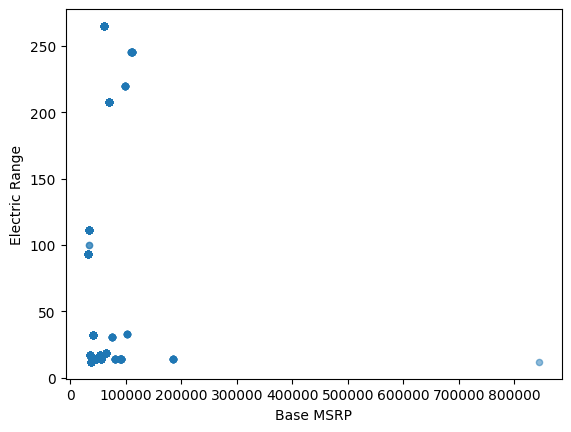

In [39]:
df[df['Base MSRP'] > 0].plot.scatter(x='Base MSRP', y='Electric Range', alpha=0.5)


In [ ]:
#pie chart showing the proportion of CAFV-eligible vs. non-eligible EVs.

<Axes: ylabel='count'>

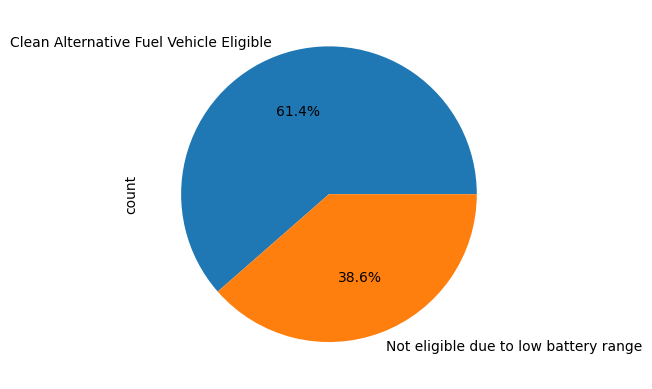

In [42]:
df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts().plot.pie(autopct='%1.1f%%')

In [ ]:
# 4. Linear Regression Model

In [ ]:
# independent variables (features) can be used to predict Electric Range

In [71]:
features = df[['Electric Range', 'Model Year', 'Base MSRP', 'Make', 'Model']].dropna()
X = features.drop(columns='Electric Range')
y = features['Electric Range']

KeyError: "['Make', 'Model'] not in index"

In [63]:
preprocess = ColumnTransformer([
    ('num', 'passthrough', ['Model Year', 'Base MSRP']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Make', 'Model'])
])

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
pipeline = Pipeline([
    ('preprocessor', preprocess),
    ('regressor', LinearRegression())
])

In [66]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [67]:
print('R² Score:', r2_score(y_test, y_pred))

R² Score: 0.9853922342980296
